In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from geopy.geocoders import Nominatim
import math
import statistics
import pandas as pd
import matplotlib.pyplot as plt

### Data processing:

In [28]:
df = pd.read_excel('data/History_2.xlsx')
df.head()

,Country,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"21,069.00","20,372.00","16,795.00","20,273.00","23,155.00","22,053.00","27,190.00",NaN,NaN,NaN
1,Czechia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1555.86,1402.87,1527.92,1522.36,1561.29,1621.08,1625.33,1867.32,2375.41,2249.71
2,Denmark,5431.88,"6,511.00",6698.78,6061.73,6025.38,6364.14,"6,537.20",6274.61,5886.54,...,"10,330.30",12211.32,12919.72,14668.87,15994.84,18787.41,22790.95,27111.91,31652.36,25919.26
3,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11810.62,11422.56,...,"9,081.00","9,427.00","9,465.00","9,184.00","9,233.00","8,692.00","8,909.00",NaN,NaN,NaN
4,Ireland,4326.26,"4,143.00",3721.72,3883.08,"4,643.30",5166.93,4917.89,4944.02,4890.29,...,"12,816.00","13,897.00","13,574.00","14,397.00","16,258.00","16,230.00",NaN,NaN,NaN,NaN


In [29]:
Countries_test = {}
for index,data in df.iterrows():
    num_of_null = 0
    avg = 0
    count = 0
    nums = []
    for i in range(1985,2010):
        value = data[str(i)]
        if type(value) == str:
            value = float(value.replace(",",""))
        if  math.isnan(value):
            num_of_null += 1
        else:
            avg += value
            count += 1
            nums.append(value)
    
    Countries_test[data["Country"]] = {"avg": round(avg / count,2) if count != 0 else math.nan, 
                                       "null%": round((num_of_null / (num_of_null + count)) * 100,2),
                                       "mean": round(statistics.mean(nums),2)
                                       }
Countries_test

{'Belgium': {'avg': 18632.2, 'null%': 52.0, 'mean': 18632.2},
 'Czechia': {'avg': 1730.91, 'null%': 60.0, 'mean': 1730.91},
 'Denmark': {'avg': 11963.84, 'null%': 0.0, 'mean': 11963.84},
 'Germany': {'avg': 9921.01, 'null%': 40.0, 'mean': 9921.01},
 'Ireland': {'avg': 8226.31, 'null%': 16.0, 'mean': 8226.31},
 'Spain': {'avg': 6779.92, 'null%': 0.0, 'mean': 6779.92},
 'France': {'avg': 4775.71, 'null%': 72.0, 'mean': 4775.71},
 'Italy': {'avg': 12317.62, 'null%': 32.0, 'mean': 12317.62},
 'Latvia': {'avg': 1818.62, 'null%': 68.0, 'mean': 1818.62},
 'Lithuania': {'avg': 602.64, 'null%': 60.0, 'mean': 602.64},
 'Luxembourg': {'avg': 16818.0, 'null%': 72.0, 'mean': 16818.0},
 'Malta': {'avg': 129963.71, 'null%': 80.0, 'mean': 129963.71},
 'Netherlands': {'avg': 32819.38, 'null%': 44.0, 'mean': 32819.38},
 'Romania': {'avg': 389.48, 'null%': 76.0, 'mean': 389.49},
 'Slovakia': {'avg': 1010.36, 'null%': 60.0, 'mean': 1010.36},
 'Finland': {'avg': 4676.78, 'null%': 0.0, 'mean': 4676.78},
 'S

In [30]:
Countries = {}

for index,data in df.iterrows():
    longest_chain = []
    current_longest = []
    start_year = 1985
    for i in range(1985,2010):
        value = data[str(i)]
        if type(value) == str:
            if  math.isnan(float(data[str(i)].replace(",",""))):
                start_year = start_year if len(current_longest) > len(longest_chain) else i - len(longest_chain) 
                current_longest = current_longest if len(current_longest) > len(longest_chain) else longest_chain
                longest_chain = []
            else:
                longest_chain.append(float(data[str(i)].replace(",","")))
        else:
            if  math.isnan(data[str(i)]):
                start_year = start_year if len(current_longest) > len(longest_chain) else i - len(longest_chain)
                current_longest = current_longest if len(current_longest) > len(longest_chain) else longest_chain
                longest_chain = []
            else:
                longest_chain.append(data[str(i)])
    start_year = start_year if len(current_longest) > len(longest_chain) else i - len(longest_chain) + 1            
    current_longest = current_longest if len(current_longest) > len(longest_chain) else longest_chain
    Countries[data["Country"]] = (current_longest,start_year)

Countries

{'Belgium': ([9727.14,
   12175.29,
   13566.99,
   18819.0,
   18391.0,
   21069.0,
   20372.0,
   16795.0,
   20273.0,
   23155.0,
   22053.0,
   27190.0],
  1995),
 'Czechia': ([1555.86,
   1402.87,
   1527.92,
   1522.36,
   1561.29,
   1621.08,
   1625.33,
   1867.32,
   2375.41,
   2249.71],
  2000),
 'Denmark': ([5431.88,
   6511.0,
   6698.78,
   6061.73,
   6025.38,
   6364.14,
   6537.2,
   6274.61,
   5886.54,
   6482.59,
   7607.76,
   8050.99,
   8552.02,
   9734.24,
   10490.22,
   10330.3,
   12211.32,
   12919.72,
   14668.87,
   15994.84,
   18787.41,
   22790.95,
   27111.91,
   31652.36,
   25919.26],
  1985),
 'Germany': ([11810.62,
   11422.56,
   11348.65,
   11356.6,
   10645.96,
   9864.89,
   9435.84,
   8939.0,
   9081.0,
   9427.0,
   9465.0,
   9184.0,
   9233.0,
   8692.0,
   8909.0],
  1992),
 'Ireland': ([4326.26,
   4143.0,
   3721.72,
   3883.08,
   4643.3,
   5166.93,
   4917.89,
   4944.02,
   4890.29,
   5311.12,
   5441.8,
   6718.8,
   7321.29,
   

In [31]:
def toTensor(country_dataset, seq_length=3):
    all_x, all_y,scalers = [], [], []

    for name, data in country_dataset.items():
        seq = data[0]
        if len(seq) <= seq_length:
            continue
            
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(np.array(seq).reshape(-1,1)).flatten()

        for i in range(len(scaled) - seq_length):
            prev = scaled[i:i+seq_length]
            target = scaled[i+seq_length]

            all_x.append(prev)
            all_y.append(target)
            scalers.append(scaler)
    
    return torch.tensor(np.array(all_x), dtype=torch.float32).unsqueeze(-1), torch.tensor(np.array(all_y), dtype=torch.float32), scalers

x,y,scalers = toTensor(Countries)
print(x.shape, y.shape)
print(len(x))

torch.Size([263, 3, 1]) torch.Size([263])
263


In [32]:
train_size = int(len(x) * 0.67)

train_x = x[:train_size]
test_x = x[train_size:]
train_y = y[:train_size]
test_y = y[train_size:]
train_s = scalers[:train_size] 
test_s = scalers[train_size:]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(train_x.shape,test_x.shape)

torch.Size([176, 3, 1]) torch.Size([87, 3, 1])


### Model:

In [33]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_dim, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_dim,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[:,-1,:])
        return out

### Train the model:

In [34]:
LR = 0.0001
num_epochs = 2000

In [35]:
train_ds = TensorDataset(train_x.float(), train_y.float())
test_ds = TensorDataset(test_x.float(), test_y.float())

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=8)

model = LSTMModel(1, 128).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.view(-1, 1).to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.view(-1, 1).to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Val_loss: {val_loss:.4f}")

Epoch 1, Loss: 4.7723, Val_loss: 1.9944
Epoch 2, Loss: 4.0306, Val_loss: 1.6542
Epoch 3, Loss: 3.3275, Val_loss: 1.3403
Epoch 4, Loss: 2.6914, Val_loss: 1.0858
Epoch 5, Loss: 2.2601, Val_loss: 0.9611
Epoch 6, Loss: 2.0869, Val_loss: 0.9277
Epoch 7, Loss: 2.0320, Val_loss: 0.8970
Epoch 8, Loss: 1.9769, Val_loss: 0.8648
Epoch 9, Loss: 1.9372, Val_loss: 0.8332
Epoch 10, Loss: 1.8815, Val_loss: 0.7981
Epoch 11, Loss: 1.8225, Val_loss: 0.7685
Epoch 12, Loss: 1.7714, Val_loss: 0.7289
Epoch 13, Loss: 1.7185, Val_loss: 0.6912
Epoch 14, Loss: 1.6628, Val_loss: 0.6565
Epoch 15, Loss: 1.6153, Val_loss: 0.6220
Epoch 16, Loss: 1.5711, Val_loss: 0.5870
Epoch 17, Loss: 1.5294, Val_loss: 0.5542
Epoch 18, Loss: 1.4893, Val_loss: 0.5233
Epoch 19, Loss: 1.4601, Val_loss: 0.4949
Epoch 20, Loss: 1.4413, Val_loss: 0.4729
Epoch 21, Loss: 1.3997, Val_loss: 0.4469
Epoch 22, Loss: 1.3844, Val_loss: 0.4384
Epoch 23, Loss: 1.3704, Val_loss: 0.4182
Epoch 24, Loss: 1.3605, Val_loss: 0.4043
Epoch 25, Loss: 1.3429, V

In [36]:
model.eval()
with torch.no_grad():
    x = 0
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.view(-1, 1).to(device)
        pred = model(xb)
        scale = test_s[x * 8]
        print("Pred:" + str(scale.inverse_transform(pred[0].cpu().numpy().reshape(-1, 1))[0][0]))
        print("True:" + str(scale.inverse_transform(yb[0].cpu().numpy().reshape(-1, 1))[0][0]))
        print('__________')
        x += 1
         

Pred:2297.2708
True:2019.4099
__________
Pred:10257.309
True:10129.95
__________
Pred:14703.911
True:16035.89
__________
Pred:5279.478
True:5571.58
__________
Pred:10585.636
True:11046.069
__________
Pred:5254.292
True:3325.4302
__________
Pred:8368.317
True:8172.54
__________
Pred:2632.1824
True:2514.53
__________
Pred:2776.2239
True:4213.27
__________
Pred:6881.852
True:4795.92
__________
Pred:16170.265
True:12549.72
__________


C:\Users\jensh\AppData\Local\Temp\ipykernel_22252\3423409019.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


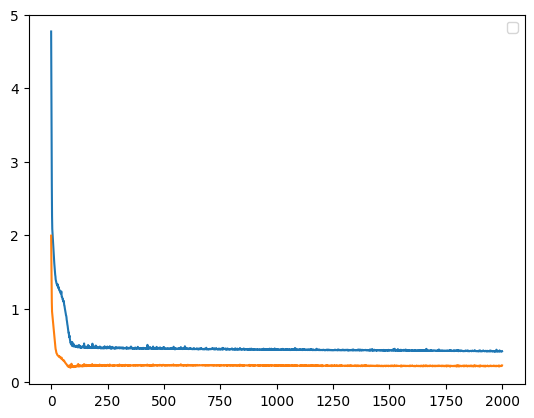

In [37]:
plt.plot(losses)
plt.plot(val_losses)
plt.legend()
plt.show()

### Predict the Price:

In [38]:
def toTensorPred(dataset, seq_length=3):
    if len(dataset) < seq_length:
        return False

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(np.array(dataset).reshape(-1,1)).flatten()

    return scaled[-seq_length:], scaler



In [39]:
def inflation_value(i):
    return math.pow((1+0.03), i)

def predict_end_year(input_sequence,start_year, end_year):
    start_year_a = start_year + len(input_sequence) - 1
    inp_seq, sc = toTensorPred(input_sequence)

    values = []
    
    for i in range(end_year - start_year_a):
        inp = torch.tensor(inp_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
        with torch.no_grad():
            pred = model(inp)
        pred_value = pred.item()
        inf = inflation_value(i)
        values.append(sc.inverse_transform([[pred_value]])[0][0] * inf)
        inp_seq = np.append(inp_seq[1:],pred_value)

    return values

test = predict_end_year(Countries["Denmark"][0],Countries["Denmark"][1],2024)

1985
prediction with accounted inflation: 39274.84225427539
goals: 21,421


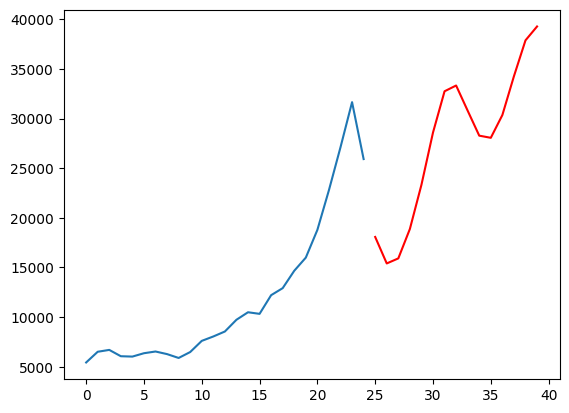

In [40]:
print(Countries["Denmark"][1])
print("prediction with accounted inflation: " + str(test[-1]))
print("goals: 21,421")
plt.plot(Countries["Denmark"][0], label='Original')
plt.plot(range(len(Countries["Denmark"][0]), len(Countries["Denmark"][0]) + len(test)), test, label='Forecast', color='red')
plt.show()

In [45]:
def predict_end_year_from_cords(lat, long, end_year):
    geolocator = Nominatim(user_agent="my_geopy_app")

    location = geolocator.reverse(str(lat)+","+str(long), language='en')

    address = location.raw['address']
    country = address['country']
    
    if(country in Countries.keys()):
        return round(predict_end_year(Countries[country][0],Countries[country][1],end_year)[-1],2)
    else:
        avg_pred = []
        for c in Countries.keys():
            avg_pred.append(predict_end_year(Countries[c][0],Countries[c][1],end_year)[-1])
        return round(statistics.mean(avg_pred),2)
        

predict_end_year_from_cords(-33.9248685,18.4240553,2024)

25988.82